In [19]:
from astropy.io import fits
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D,SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2

galaxy_name = 'DDO133'
box_size = 200
window_size = (40, 40)


# import files----------------------------------------------------------------------------------------------------------------------------------------------------
light_file_u = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 133\d133u.fits")
light_u = light_file_u[0].data

light_file_b = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 133\d133b.fits")
light_b = light_file_b[0].data

light_file_v = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Data\DDO 133\d133v.fits")
light_v = light_file_v[0].data

box_u = (100 , 100)
box_b = (130 , 130)
box_v = (170 , 170)

lights = [light_u,light_b,light_v]
boxes = [box_u,box_b,box_v]
filters = ["U" , "B" , "V"]
print(np.shape(light_u), np.shape(light_b), np.shape(light_v))

(942, 942) (942, 942) (942, 942)


(942, 942) (942, 942) (942, 942)


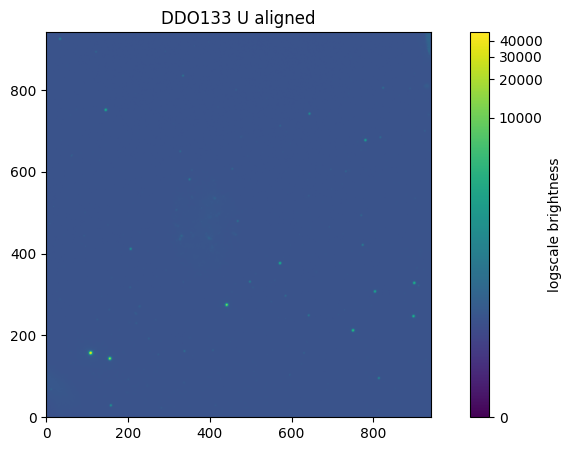

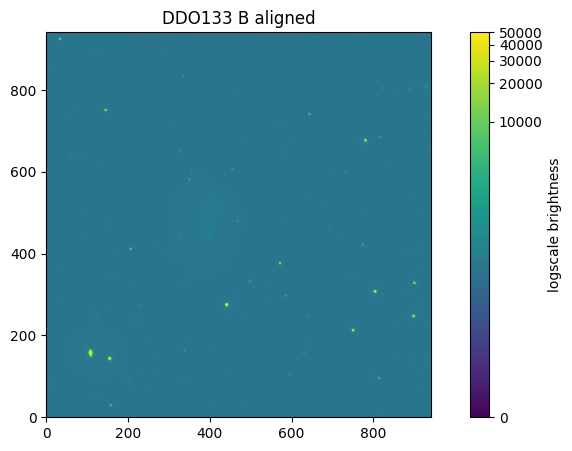

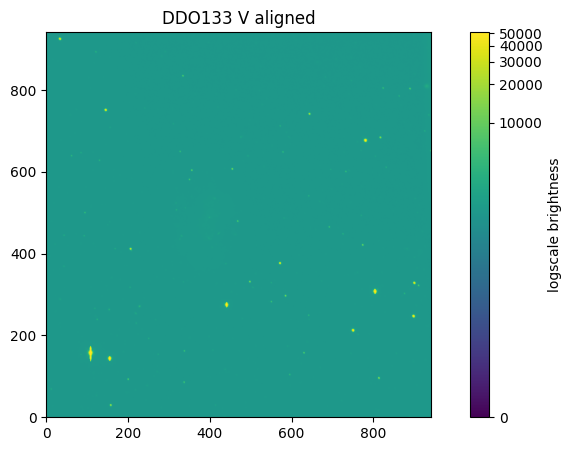

In [20]:
import astroalign as aa
target_fixed = lights[2].byteswap().newbyteorder('N')
source_fixed_1 = lights[0].byteswap().newbyteorder('N')
source_fixed_2 = lights[1].byteswap().newbyteorder('N')

registered_image_1, footprint_1 = aa.register(source_fixed_1, target_fixed)
registered_image_2,  footprint_2 = aa.register(source_fixed_2, target_fixed)
list_of_aligned_images = [registered_image_1, registered_image_2, lights[2] ]

print(np.shape(list_of_aligned_images[1]),np.shape(list_of_aligned_images[2]), np.shape(list_of_aligned_images[2]))
aligned = list_of_aligned_images

for i in range(0,3):
    ltf.log_scale_plot(aligned[i],"%s %s aligned"%(galaxy_name,filters[i]),"logscale brightness")

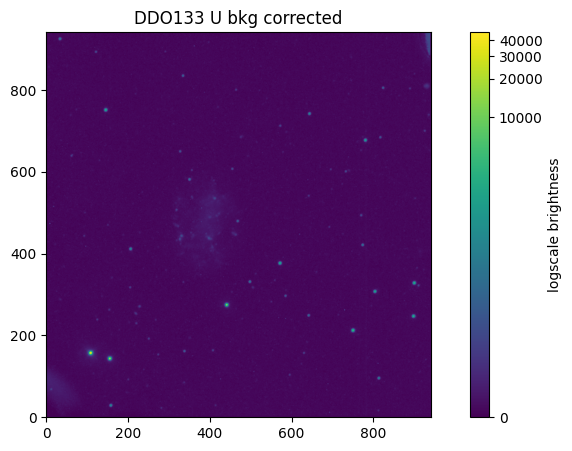

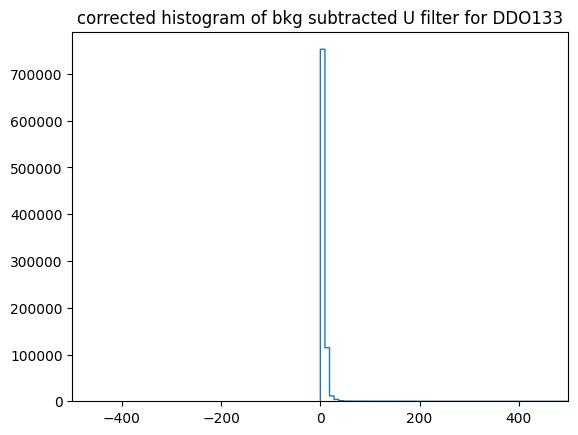

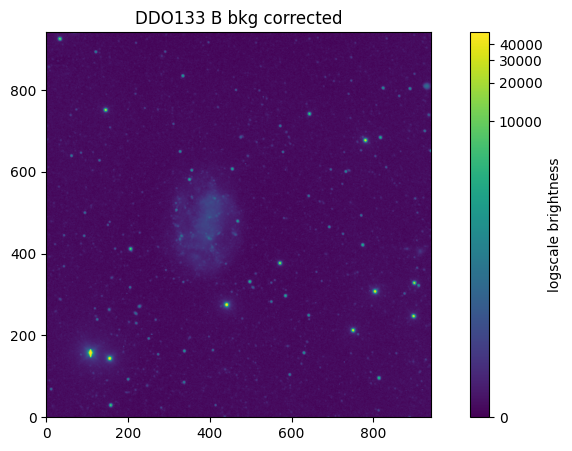

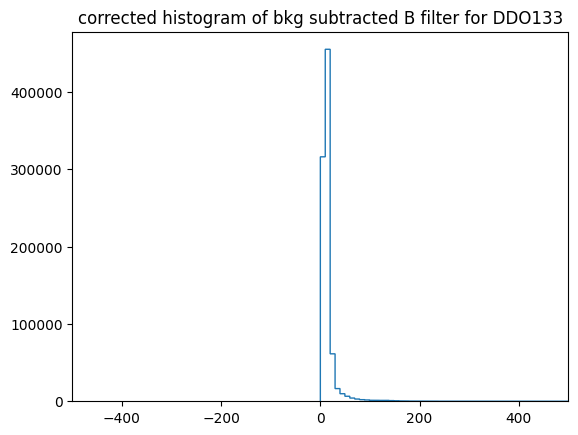

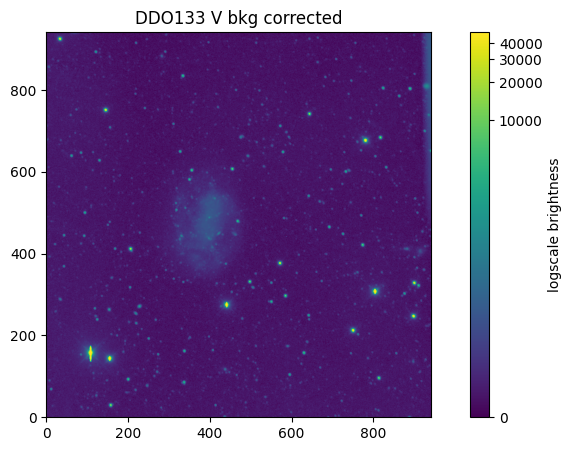

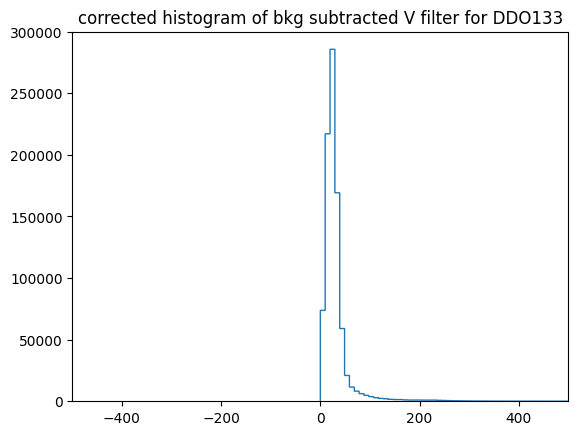

In [21]:
corrected = ltf.background_subtraction(aligned,3,boxes,(3,3))
for i in range(0,3):
    ltf.log_scale_plot(corrected[i],"%s %s bkg corrected"%(galaxy_name,filters[i]),"logscale brightness")
    output_filename = '%s_%s_background_subtracted.fits'%(galaxy_name,filters[i])
    # Create a PrimaryHDU (header/data unit) from your array
    primary_hdu = fits.PrimaryHDU(corrected[i])
    # Create an HDUList and append the PrimaryHDU
    hdul = fits.HDUList([primary_hdu])
    # Write the HDUList to the FITS file
    #hdul.writeto(output_filename, overwrite=True)
    counts, bins = np.histogram(corrected[i], 5000)
    plt.stairs(counts, bins)
    plt.xlim([-500, 500])
    plt.title("corrected histogram of bkg subtracted %s filter for %s" %(filters[i] , galaxy_name))
    plt.show()

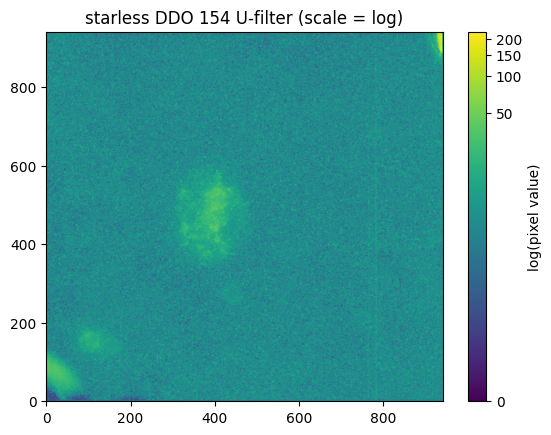

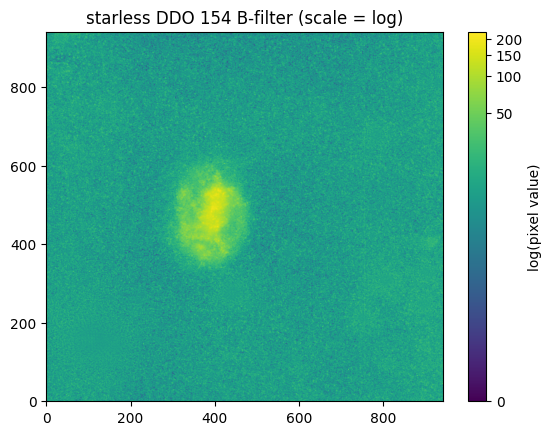

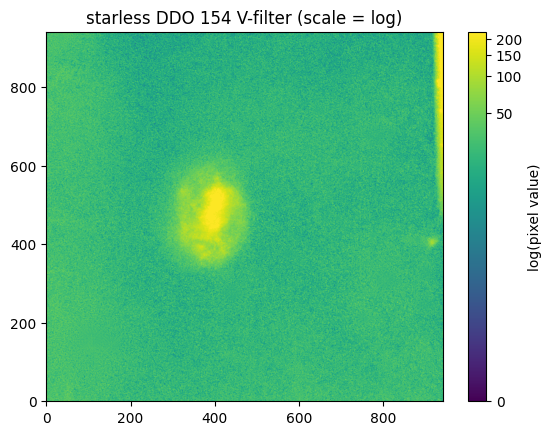

In [22]:
# import starless files----------------------------------------------------------------------------------------------------------------------------------------------------
starless_file_u = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d133\starless\starless_DDO133_U_background_subtracted.fit")
starless_u = starless_file_u[0].data
starless_u[starless_u <= 0] = 1
starless_file_b = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d133\starless\starless_DDO133_b_background_subtracted.fit")
starless_b = starless_file_b[0].data
starless_b[starless_b <= 0] = 1
starless_file_v = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Code\d133\starless\starless_DDO133_v_background_subtracted.fit")
starless_v = starless_file_v[0].data
starless_v[starless_v <= 0] = 1

starless = [starless_u , starless_b , starless_v]

norm = ImageNormalize(vmin=0., stretch=LogStretch())
for i in range(0 , len(starless)):
    
    plt.imshow(starless[i] , origin = "lower" , aspect='auto', norm = norm)
    plt.title('starless DDO 154 %s-filter (scale = log)'%(filters[i]))
    cbar = plt.colorbar()
    cbar.set_label('log(pixel value)')
    plt.show()

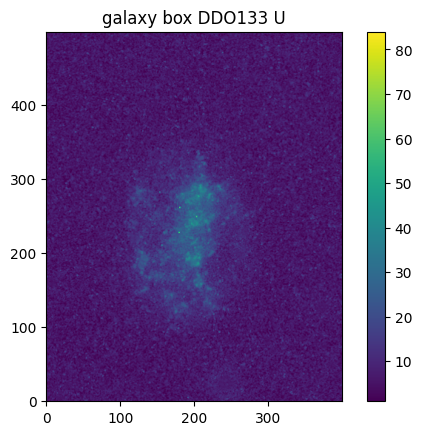

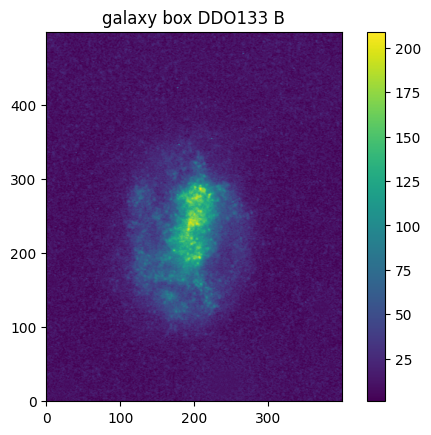

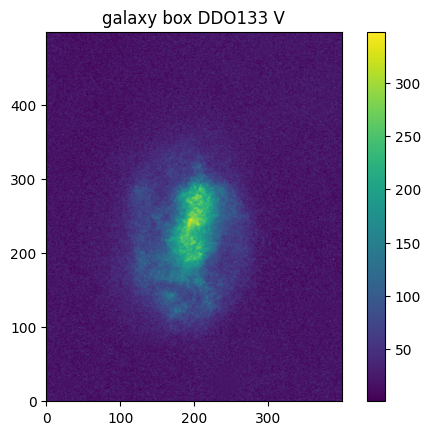

In [23]:
box_size_x = 200
box_size_y = 250
box_center = [400,500]

galaxy_boxes = []
for i in range(0 , len(starless)):
        box = starless[i][box_center[1] - box_size_y : box_center[1] + box_size_y, box_center[0] - box_size_x : box_center[0] + box_size_x]
        galaxy_boxes.append(box)
for i in range(0,3):
    plt.imshow(galaxy_boxes[i], origin = "lower")
    plt.title("galaxy box %s %s"%(galaxy_name,filters[i]))
    plt.colorbar()
    plt.show()
    

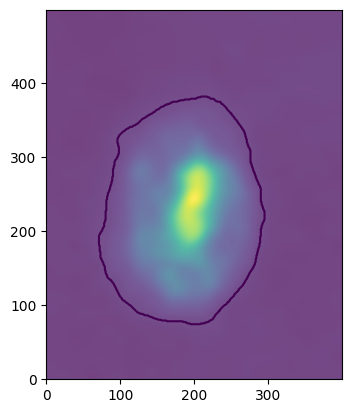

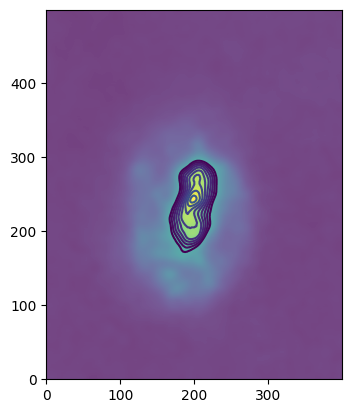

In [24]:
v_value_box = galaxy_boxes[2]
smoothed = gaussian_filter(v_value_box, 5)
contour_points = ltf.contour_lines_coordinates(smoothed, 5, [25])
x_points , y_points = contour_points
plt.show()

levels = np.asanyarray(np.arange(150, 600, 15))
ltf.contour_lines(v_value_box, 5, levels)
plt.show()

(238.4522830245935, 197.49725556175966)
108.6383472210373
[ 1.83634810e+02  2.24349757e+02  1.08638347e+02  1.55694817e+02
 -1.02854249e-01]


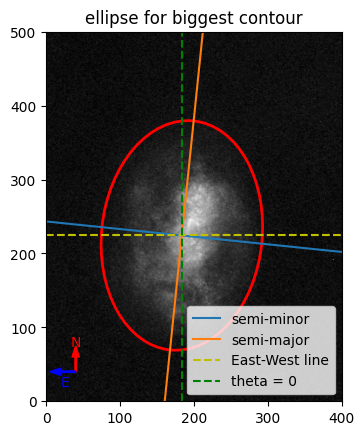

what we measure  -5.893114392114154
paper = -6


In [25]:
image_center_of_mass = ndimage.center_of_mass(v_value_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

xc, yc, a, b, theta = popt
print(a)
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(v_value_box, cmap='gray' , origin = "lower")

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)

m = np.tan(theta)
x_ax = np.arange(0,400)
Y_ax = m*(x_ax-xc) + yc
ax.plot(x_ax,Y_ax, label = "semi-minor")

Y_prime_ax = (-1/m)*(x_ax-xc) + yc
ax.plot(x_ax,Y_prime_ax, label="semi-major")

plt.axhline(y=yc, color='y', linestyle='--', label = "East-West line")
plt.axvline(x=xc,  color='g', linestyle='--', label="theta = 0")

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_value_box.shape[1])
ax.set_ylim(0,v_value_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for vlaue = 30, DDO168 V")
# Show the plot
# Example: Add arrows for north and east
plt.arrow(x=40, y=40, dx=0, dy=20, color='red', width=2, head_width=10)
plt.arrow(x=40, y=40, dx=-20, dy=0, color='blue', width=2, head_width=10)
plt.text(40, 80, 'N', color='red', fontsize=10, ha='center', va='center')
plt.text(25, 25, 'E', color='blue', fontsize=10, ha='center', va='center')

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_value_box.shape[1])
ax.set_ylim(0,v_value_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for biggest contour")
plt.legend()
# Show the plot
plt.show()
import math
angle_in_degrees = math.degrees(theta)

print("what we measure " , angle_in_degrees)


print("paper = -6")

C:\Users\AYSAN\AppData\Local\Temp\ipykernel_24988\1695093212.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry


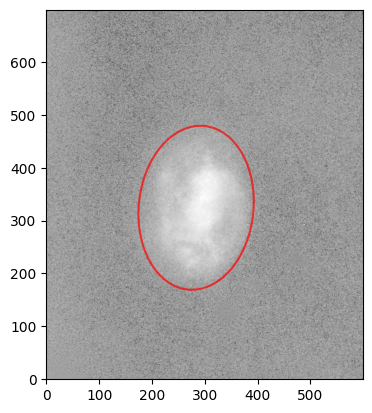

In [26]:
from astropy.coordinates import Angle
from photutils.aperture import EllipticalAperture
from photutils import aperture_photometry
plus = 100
bigger_v_box = starless[2][box_center[1] - (box_size_y+plus) : box_center[1] + (box_size_y+plus), box_center[0] - (box_size_x+plus) : box_center[0] + (box_size_x+plus)]

elliptical_center_box = (xc,yc)
new_xc = xc + int(plus)
new_yc = yc + int(plus)
elliptical_center = (new_xc,new_yc)
ellipse_aper = EllipticalAperture(elliptical_center, a, b, theta)
norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.imshow(bigger_v_box, cmap='gray', origin = "lower" , norm = norm) 
ellipse_aper.plot(color='red', lw=1.5, alpha=0.7) 
plt.show()
phot_table = aperture_photometry(bigger_v_box, ellipse_aper)
aperture_sum_A = phot_table['aperture_sum'][0] 

C:\Users\AYSAN\AppData\Local\Temp\ipykernel_24988\2257863402.py:3: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry
C:\Users\AYSAN\AppData\Local\Temp\ipykernel_24988\2257863402.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry


0.6977647014429478
Aperture sums: [7.665486074759096e-10, 5059.0167467705405, 20321.59598594329, 44953.49614815027, 79553.16760646859, 121951.78933840132, 172689.1107823583, 231002.1797700371, 296299.34792631876, 367148.60029763513, 442853.276052249, 524154.1057439818, 611055.3137161392, 701822.4057274645, 797879.8195687132, 898191.6995806843, 1001114.6172063269, 1106879.6342867643, 1214083.6022449217, 1321777.8350455747, 1427824.0341787697, 1533248.9055041233, 1638386.7889876962, 1741379.5771505453, 1841406.256567906, 1939520.4398242037, 2038188.760710265, 2136462.9292348973, 2235182.1160859987, 2334148.342166992, 2432306.870110249, 2529610.2485126723, 2627268.1636028537, 2724449.569191743, 2819750.976815766, 2913429.38411962, 3004189.600012358, 3092440.348497696, 3177389.8206820977, 3258630.8480347274, 3336048.713805071, 3411906.680756777, 3484372.899042698, 3552407.396672343, 3620429.118220996, 3685551.9614783246, 3749530.7192685977, 3810558.6891590236, 3869420.108226862, 3927704.18

Text(0.5, 1.0, ' curve of growth for DDO154')

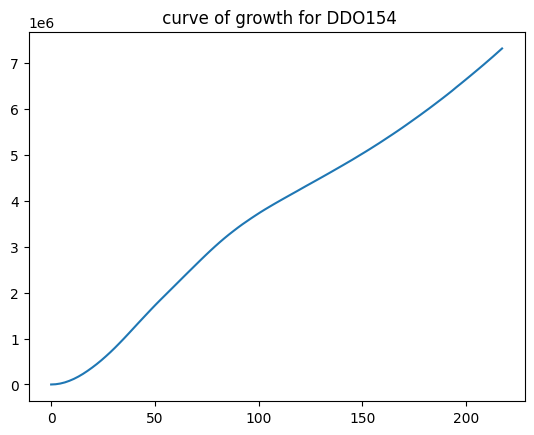

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from photutils import EllipticalAperture, aperture_photometry

# Assuming you have defined 'a', 'b', 'theta', 'elliptical_center', and 'v_value_box'
ab_ratio = a / b
ba_ratio = b / a
print(ab_ratio)
a_list = np.linspace(0, 2*a, 100)
b_list = ba_ratio * a_list

sum_values = []

for i in range(len(a_list)):
    # Ensure positive scalar values for major and minor axes
    a_i = max(a_list[i], 1e-6)  # Avoid zero or negative values
    b_i = max(b_list[i], 1e-6)
    ellipse_aper = EllipticalAperture(elliptical_center, a_i, b_i, theta)
    '''
    plt.imshow(bigger_v_box, cmap='gray')  # Replace 'image_data' with your data
    ellipse_aper.plot(color='red', lw=1.5, alpha=0.7)  # Overlay the aperture
    plt.show()
    '''
    # Compute the aperture sum
    phot_table = aperture_photometry(bigger_v_box, ellipse_aper)
    aperture_sum_A = phot_table['aperture_sum'][0]
    sum_values.append(aperture_sum_A)

print("Aperture sums:", sum_values)

plt.plot(a_list , sum_values)
plt.title(" curve of growth for DDO154")

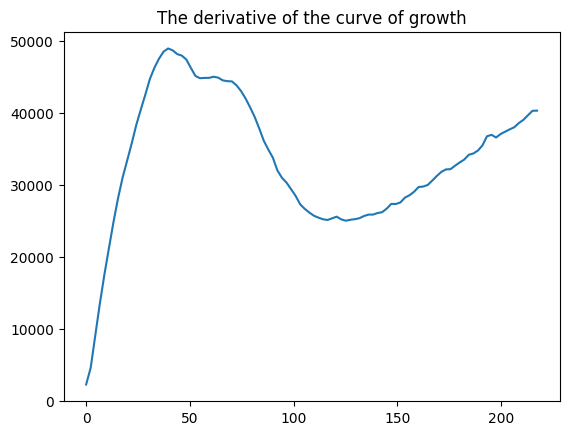

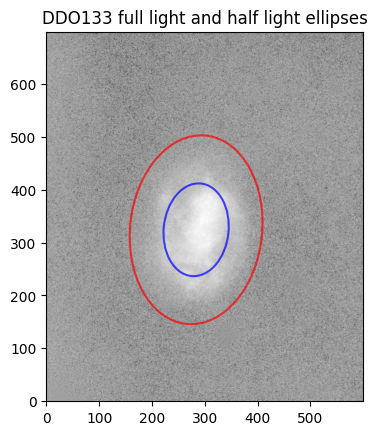

galaxy parameter a =  125.09870286058839 and galaxy parameter b =  179.28494032714693
galaxy count 4373640.528232892
galaxy half light a =  61.45199438765746 and galaxy half light b =  88.06979524842306
half light count 2235182.1160859987
-0.10285424933905615


In [28]:
gradient_sum = np.gradient(sum_values, a_list)
plt.title("The derivative of the curve of growth")
plt.plot(a_list, gradient_sum)
plt.show()
import numpy as np
from scipy.signal import find_peaks
peaks, _ = find_peaks(gradient_sum)
peak_index = peaks[0]
min_after_peak = np.min(gradient_sum[peak_index + 1:])
min_index_after_peak = np.where(gradient_sum == min_after_peak)[0][0]

galaxy_parameter_a = a_list[min_index_after_peak]
galaxy_parameter_b = galaxy_parameter_a*ba_ratio
whole_galaxy = sum_values[min_index_after_peak]

half_light_estimated = whole_galaxy/2
half_light_index = min(range(len(sum_values)), key=lambda i: abs(sum_values[i] - half_light_estimated))

a_half_light = a_list[half_light_index]
b_half_light = a_half_light * ba_ratio

ellipse_aper_full_light = EllipticalAperture(elliptical_center, galaxy_parameter_a, galaxy_parameter_b, theta)
ellipse_aper_half_light = EllipticalAperture(elliptical_center, a_half_light, b_half_light, theta)
norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.imshow(bigger_v_box, cmap='gray', origin = "lower" , norm = norm) 
ellipse_aper_full_light.plot(color='red', lw=1.5, alpha=0.7) 
ellipse_aper_half_light.plot(color='blue', lw=1.5, alpha=0.7)
plt.title("%s full light and half light ellipses" %(galaxy_name))
plt.show()

print("galaxy parameter a = ", galaxy_parameter_a, "and galaxy parameter b = " , galaxy_parameter_b)
print("galaxy count", sum_values[min_index_after_peak])
print("galaxy half light a = ", a_half_light, "and galaxy half light b = " , b_half_light)
print("half light count", sum_values[half_light_index])
ratio = sum_values[half_light_index]/whole_galaxy
print(theta)

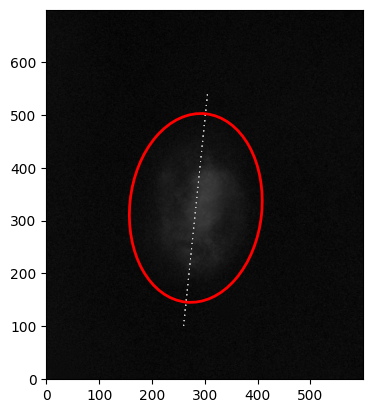

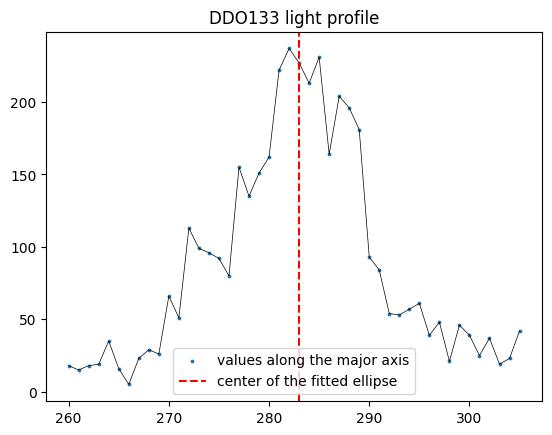

In [29]:
new_xc = int(new_xc)
new_yc = int(new_yc)
x_ax_left = np.arange(260, new_xc)
x_ax_right = np.arange(new_xc, (new_xc-260)+new_xc)
import copy
duplicated_array = copy.copy(bigger_v_box)
def get_line_values(array, yc, x_ax):
    values = []
    for x in x_ax:
        y = int(-1/m * (x) + yc - (-1/m)*new_xc)
        values.append(array[y, x])
        duplicated_array = copy.copy(array)
        array[y, x] = 65535
            
    return values

norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.figure()
ax = plt.gca()
values_along_line_left = get_line_values(bigger_v_box, new_yc, x_ax_left)
values_along_line_right = get_line_values(bigger_v_box, new_yc, x_ax_right)

# Display the other image
ax.imshow(bigger_v_box, cmap='gray' , origin = "lower", norm = norm)
angle_in_degrees = np.degrees(theta)
# Create the ellipse
ellipse = Ellipse(xy=(new_xc, new_yc), width=2*galaxy_parameter_a, height=2*galaxy_parameter_b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)
# Add the ellipse to the axis
ax.add_patch(ellipse)
plt.show()
values_along_line = values_along_line_left + values_along_line_right
   
x_ax = np.arange(np.min(x_ax_left), np.max(x_ax_right)+1)
plt.scatter(x_ax , values_along_line, s = 3, label='values along the major axis')
plt.plot(x_ax , values_along_line, color = "black" , linewidth = 0.5)
plt.axvline(x=new_xc, color='r', linestyle='--', label='center of the fitted ellipse')
plt.legend()
plt.title("DDO133 light profile")
plt.show()

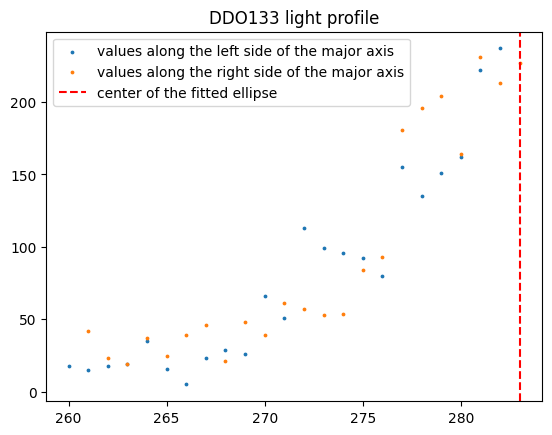

46


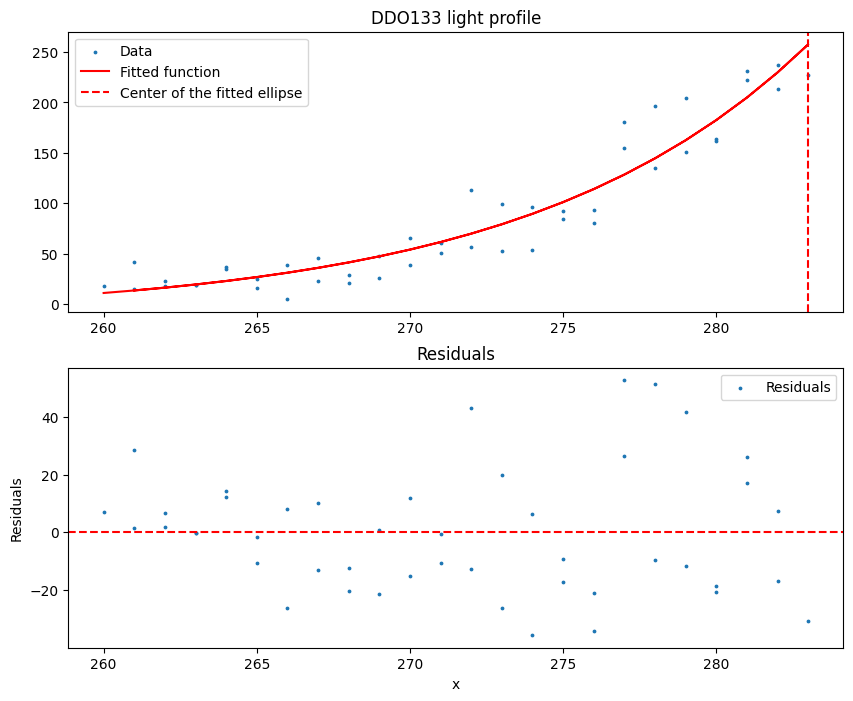

<Figure size 640x480 with 0 Axes>

Exponential fit function is a * exp(b * (x - x0)) + c
a is 0.0001 +/- 395.9527
b is 0.1094 +/- 0.0191
c is -10.7155 +/- 16.5223
x0 is 142.9262 +/- 60890886.3433
b is 0.1094 +/- 0.0191
1/b is 9.1424


In [37]:
L = len(x_ax_left)
new_x_ax_right = []
for i in range(0,len(x_ax_right)):
    x = (2*L-x_ax_right[i] + 2*260)
    new_x_ax_right.append(x)
    

plt.scatter(x_ax_left , values_along_line_left, s = 3, label='values along the left side of the major axis')
plt.scatter(new_x_ax_right , values_along_line_right, s = 3, label='values along the right side of the major axis')
plt.axvline(x=new_xc, color='r', linestyle='--', label='center of the fitted ellipse')
plt.legend()
plt.title("DDO133 light profile")
plt.show()

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

x1 = x_ax_left # Your x values
x2 = new_x_ax_right
y1 = values_along_line_left
y2 = values_along_line_right
# Combine y-values
y_combined = np.concatenate((y1, y2))
print(len(y_combined))
x_combined = np.concatenate((x1, x2))

def exponential_func(x, a, b, c, x0):
    return a * np.exp(b * (x - x0)) + c

# Provide initial guesses for the parameters
initial_guesses = [1, 0.06, 25, 0]
popt, pcov = curve_fit(exponential_func, x_combined, y_combined, p0=initial_guesses)

# Plot the original data and the fitted function
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
plt.scatter(x_combined, y_combined, s=3, label='Data')
plt.plot(x_combined, exponential_func(x_combined, *popt), label='Fitted function', color='red')
plt.axvline(x=new_xc, color='r', linestyle='--', label='Center of the fitted ellipse')
plt.legend()
plt.title("DDO133 light profile")
# Calculate residuals
residuals = y_combined - exponential_func(x_combined, *popt)

# Plot the residuals
plt.subplot(2, 1, 2)
plt.scatter(x_combined, residuals, s=3, label='Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.legend()
plt.title('Residuals')
plt.xlabel('x')
plt.ylabel('Residuals')
plt.show("DDO133 light profile")
plt.tight_layout()
plt.show()

# Calculate the standard deviation errors on the parameters
perr = np.sqrt(np.diag(pcov))
print("Exponential fit function is a * exp(b * (x - x0)) + c")
print(f"a is {popt[0]:.4f} +/- {perr[0]:.4f}")
print(f"b is {popt[1]:.4f} +/- {perr[1]:.4f}")
print(f"c is {popt[2]:.4f} +/- {perr[2]:.4f}")
print(f"x0 is {popt[3]:.4f} +/- {perr[3]:.4f}")

print(f"b is {popt[1]:.4f} +/- {perr[1]:.4f}")
print(f"1/b is {1/popt[1]:.4f}")


Text(25, 25, 'E')

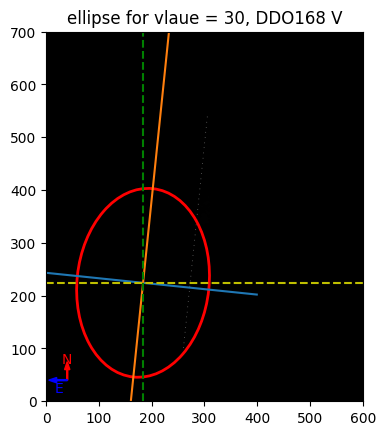

In [31]:
plt.figure()
ax = plt.gca()
# Display the other image
ax.imshow(bigger_v_box, cmap='gray' , origin = "lower")
ellipse = Ellipse(xy=(xc, yc), width=2*galaxy_parameter_a, height=2*galaxy_parameter_b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)
# Add the ellipse to the axis
ax.add_patch(ellipse)
m = np.tan(theta)
x_ax = np.arange(0,400)
Y_ax = m*(x_ax-xc) + yc
ax.plot(x_ax,Y_ax)

Y_prime_ax = (-1/m)*(x_ax-xc) + yc
ax.plot(x_ax,Y_prime_ax)

plt.axhline(y=yc, color='y', linestyle='--')
plt.axvline(x=xc,  color='g', linestyle='--', label="theta = 0")

# Set axis limits (adjust as needed)
ax.set_xlim(0,bigger_v_box.shape[1])
ax.set_ylim(0,bigger_v_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for vlaue = 30, DDO168 V")
# Show the plot
# Example: Add arrows for north and east
plt.arrow(x=40, y=40, dx=0, dy=20, color='red', width=2, head_width=10)
plt.arrow(x=40, y=40, dx=-20, dy=0, color='blue', width=2, head_width=10)
plt.text(40, 80, 'N', color='red', fontsize=10, ha='center', va='center')
plt.text(25, 25, 'E', color='blue', fontsize=10, ha='center', va='center')


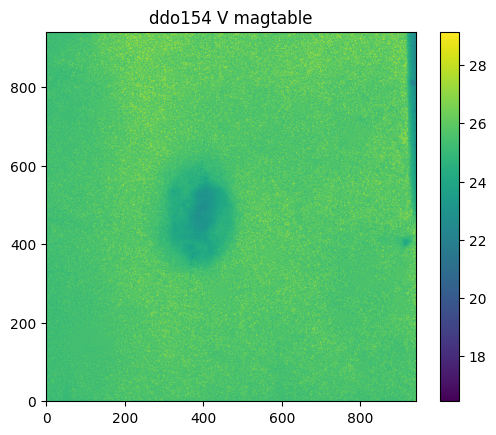

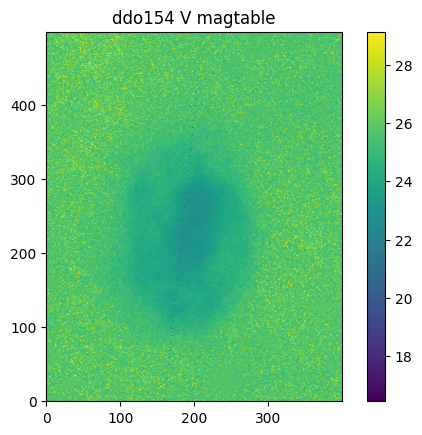

In [32]:
airmass_values=[1.16, 1.49, 1.11]
pixel_scale = 1.134
exposures = [1800, 1200, 600]
mU_values = [5.196, 0.4683865, -0.093,  0.]
mB_values = [3.562, 0.2586217, -0.0166, 0.]
mV_values = [3.017, 0.128904 ,  0.045,  0.]
m_values = [mU_values,mB_values,mV_values]

plt.imshow(ltf.mag_table_correction(starless,airmass_values,m_values,pixel_scale,exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

plt.imshow(ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

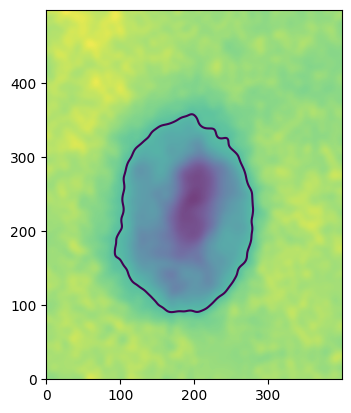

In [33]:
v_box = ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2]
contour_points = ltf.contour_lines_coordinates(v_box, 5, [25])
x_points , y_points = contour_points

In [34]:
image_center_of_mass = ndimage.center_of_mass(v_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]

(249.90237855810685, 199.48167498066698)


[ 1.87120004e+02  2.19923487e+02  9.12503488e+01  1.30510911e+02
 -2.90956903e-02]


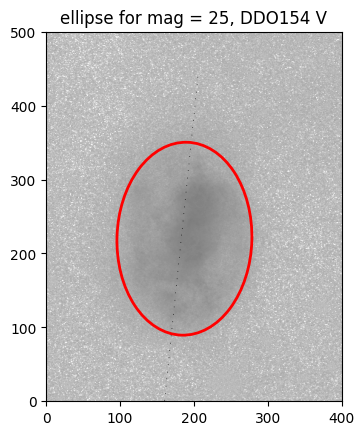

In [35]:
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse

initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

xc, yc, a, b, theta = popt
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(v_box, cmap='gray' , origin = "lower")

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_box.shape[1])
ax.set_ylim(0,v_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for mag = 25, DDO154 V")
# Show the plot
plt.show()